# Use Amazon Forecast to Predict Hourly Temperature

Using Amazon Forecast involves the following 3 steps.

![Amazon Forecast Workflow](https://github.com/aws-samples/amazon-forecast-samples/raw/main/notebooks/basic/Getting_Started/images/workflow.png)


We will start by **importing the historical data from 1960-01-01 to 2011-01-22**. Next, we will **train a Predictor** using this data. Finally, we will **generate a forecast for temperature on 2011-01-23** and **compare it with the actual data from February 2019**.

## Table of Contents
* [Pre-requisites](#prerequisites)
* Step 1: [Import data](#import)
* Step 2: [Train a predictor](#predictor)
* Step 3: [Generate forecasts](#forecast)
* Step 4: [Second predictor and forecast](#second)

## Pre-requisites <a class="anchor" id="prerequisites"></a>
Before we get started, lets set up the notebook environment, the AWS SDK client for Amazon Forecast and IAM Role used by Amazon Forecast to access your data.

#### Setup Notebook Environment

In [2]:
%%capture --no-stderr setup

!pip install pandas s3fs matplotlib ipywidgets
!pip install boto3 --upgrade

%reload_ext autoreload

#### Setup Imports

Need to download the 'util' folder from https://github.com/aws-samples/amazon-forecast-samples/tree/bb5c3914d2864d4fe2970f48cbd5a1d0a7b5244f/notebooks/common and upload to the SageMaker studio, so we can import it as a necessary package to use later.
 

In [3]:
import sys
import os

#sys.path.insert( 0, os.path.abspath(""))
import util                
#https://github.com/aws-samples/amazon-forecast-samples/tree/bb5c3914d2864d4fe2970f48cbd5a1d0a7b5244f/notebooks/common

import json
import boto3
import s3fs
import pandas as pd

#### Create an instance of AWS SDK client for Amazon Forecast

In [4]:
region = 'us-east-1'
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

# Checking to make sure we can communicate with Amazon Forecast
assert forecast.list_predictors()

## Step 1: Import your data. <a class="anchor" id="import"></a>

In this step, we will create a **Dataset** and **Import** dataset from S3 to Amazon Forecast. To train a Predictor we will need a **DatasetGroup** that groups the input **Datasets**. So, we will end this step by creating a **DatasetGroup** with the imported **Dataset**.

#### Peek at the data and upload it to S3.

The temperature dataset has the following 3 columns:
1. **timestamp:** Timetamp at which pick-ups are requested.
2. **item_id:** location ID.
3. **target_value:** Temperature in celcius degree.

#### Creating the Dataset

In [6]:
ts_s3_path = f"s3://finalprojectdata/train_tempeature.csv"

DATASET_FREQUENCY = "H" # H for hourly.
TS_DATASET_NAME = "Temp_train"
TS_SCHEMA = {
	"Attributes": [
		{
			"AttributeName": "timestamp",
			"AttributeType": "timestamp"
		},
		{
			"AttributeName": "target_value",
			"AttributeType": "float"
		},
		{
			"AttributeName": "item_id",
			"AttributeType": "string"
		}
	]
}

create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                  DatasetType='TARGET_TIME_SERIES',
                                                  DatasetName=TS_DATASET_NAME,
                                                  DataFrequency=DATASET_FREQUENCY,
                                                  Schema=TS_SCHEMA)

ts_dataset_arn = create_dataset_response['DatasetArn']
describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)

print(f"The Dataset with ARN {ts_dataset_arn} is now {describe_dataset_response['Status']}.")

The Dataset with ARN arn:aws:forecast:us-east-1:039311895032:dataset/Temp_train is now ACTIVE.


#### Importing the Dataset

In [7]:
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"
TS_IMPORT_JOB_NAME = "Temperatire_IMPORT"
role_arn = "arn:aws:iam::039311895032:role/LabRole"


ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)

print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn} to become ACTIVE. This process could take 5-10 minutes.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))

describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn} is now {describe_dataset_import_job_response['Status']}.")

Waiting for Dataset Import Job with ARN arn:aws:forecast:us-east-1:039311895032:dataset-import-job/Temp_train/Temperatire_IMPORT to become ACTIVE. This process could take 5-10 minutes.

Current Status:
CREATE_PENDING .
CREATE_IN_PROGRESS ...............................................
ACTIVE 


The Dataset Import Job with ARN arn:aws:forecast:us-east-1:039311895032:dataset-import-job/Temp_train/Temperatire_IMPORT is now ACTIVE.


#### Creating a DatasetGroup

In [8]:
DATASET_GROUP_NAME = "TEMP_DEMO"
DATASET_ARNS = [ts_dataset_arn]

create_dataset_group_response = \
    forecast.create_dataset_group(Domain="CUSTOM",
                                  DatasetGroupName=DATASET_GROUP_NAME,
                                  DatasetArns=DATASET_ARNS)

dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
describe_dataset_group_response = forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

print(f"The DatasetGroup with ARN {dataset_group_arn} is now {describe_dataset_group_response['Status']}.")


The DatasetGroup with ARN arn:aws:forecast:us-east-1:039311895032:dataset-group/TEMP_DEMO is now ACTIVE.


## Step 2: Train a predictor <a class="anchor" id="predictor"></a>

In this step, we will create a **Predictor** using the **DatasetGroup** that was created above. After creating the predictor, we will review the accuracy obtained through the backtesting process to get a quantitative understanding of the performance of the predictor.

#### Train a predictor

In [ ]:
PREDICTOR_NAME = "TEMP_PREDICTOR"
FORECAST_HORIZON = 10
FORECAST_FREQUENCY = "H"


create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = FORECAST_HORIZON,
                                   ForecastFrequency = FORECAST_FREQUENCY,
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn
                                    },
                                   ExplainPredictor = True)


#### Review accuracy metrics

* **Weighted Quantile Loss (wQL)** metric measures the accuracy of a model at a specified quantile. It is particularly useful when there are different costs for underpredicting and overpredicting.

* **Root Mean Square Error (RMSE)** uses the squared value of the residuals, which amplifies the impact of outliers. In use cases where only a few large mispredictions can be very costly, the RMSE is the more relevant metric.

* **Weighted Absolute Percentage Error (WAPE)** is more robust to outliers than Root Mean Square Error (RMSE) because it uses the absolute error instead of the squared error.

* **Mean Absolute Percentage Error (MAPE)** is useful for cases where values differ significantly between time points and outliers have a significant impact.

* **Mean Absolute Scaled Error (MASE)** is ideal for datasets that are cyclical in nature or have seasonal properties.

Since the kernel keeps losing connection during the long prediction process, we decided to directly use the predictor ARN obtained from Amazon Forecaste webpage for the model evaluation and forecaste generation.

In [5]:
predictor_arn = 'arn:aws:forecast:us-east-1:039311895032:predictor/TEMP_PREDICTOR_01HGDX8X2YNGVRAT6H3YZM9BRD'

get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}\n\n")

print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}\n\n")

print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}\n\n")

print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}\n\n")

print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}\n")

Weighted Quantile Loss (wQL): [
  {
    "Quantile": 0.9,
    "LossValue": 0.01889803081843143
  },
  {
    "Quantile": 0.5,
    "LossValue": 0.01612814734384785
  },
  {
    "Quantile": 0.1,
    "LossValue": 0.015209528616945049
  }
]


Root Mean Square Error (RMSE): 0.5636196148002091


Weighted Absolute Percentage Error (WAPE): 0.016124999153368645


Mean Absolute Percentage Error (MAPE): 0.016872251803482917


Mean Absolute Scaled Error (MASE): 0.6411181896531626



## Step 3: Generate forecasts <a class="anchor" id="forecast"></a>
Finally, we will generate the forecasts using the above predictor. Later in this step we will also compare the forecast with the ground truth temperature to demonstrate actual performance of Amazon Forecast on this dataset.

#### Generate forecasts

In [ ]:
FORECAST_NAME = "TEMP_FORECAST"

create_forecast_response = \
    forecast.create_forecast(ForecastName=FORECAST_NAME,
                             PredictorArn=predictor_arn)


#### Load ground truth for temperture 

In [36]:
item_id = '1'

temp_df = pd.read_csv("data/groundtruth_temperature.csv")
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])


start_time = pd.to_datetime('2011-01-22 15:00:00')
end_time = pd.to_datetime('2011-01-23 00:00:00')

actuals = temp_df[(temp_df['timestamp'] >= start_time) & (temp_df['timestamp'] <= end_time)]

#### Query forecasts for temperatures starting from 2011-01-22 15:00:00 to 2011-01-23 00:00:00 (total predicted timestamps contained in the predictor)

In [37]:
forecast_arn = 'arn:aws:forecast:us-east-1:039311895032:forecast/TEMP_FORECAST'

forecast_response = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": item_id}
)

forecasts_p10_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
forecasts_p50_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
forecasts_p90_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

#### Compare the forecasts with ground truth

/tmp/ipykernel_1190/3332085479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuals['timestamp'] = actuals['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_1190/3332085479.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} , ignore_index=True)
/tmp/ipykernel_1190/3332085479.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} ,

<AxesSubplot:xlabel='timestamp'>

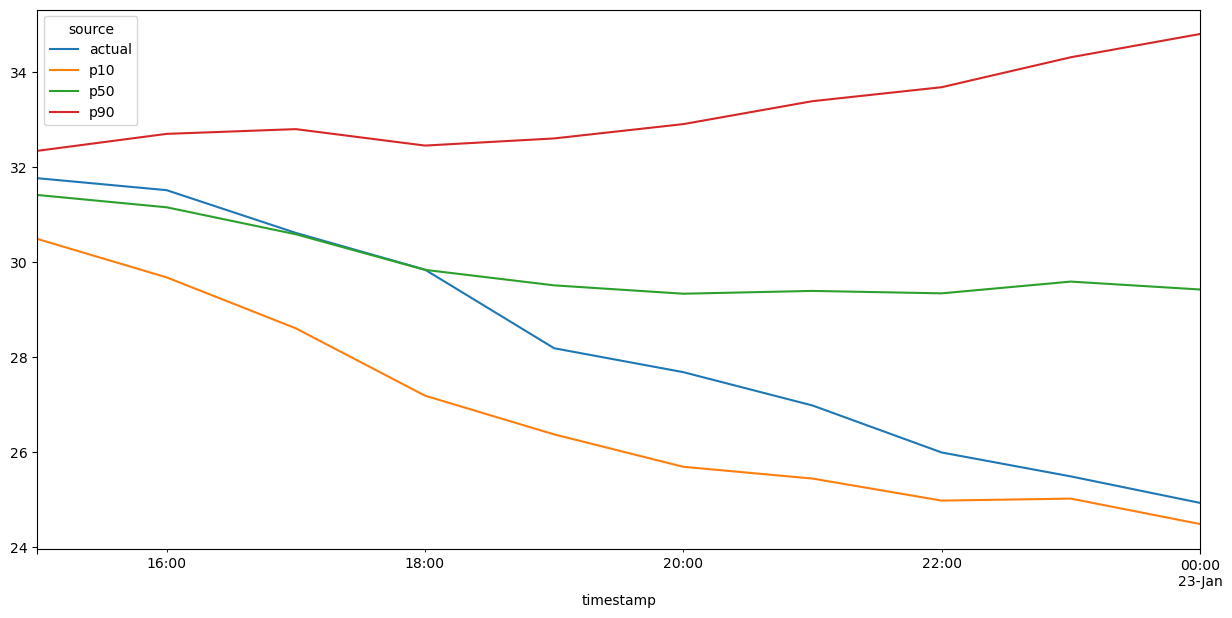

In [38]:
import dateutil.parser

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])
actuals['timestamp'] = actuals['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')


for index, row in actuals.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} , ignore_index=True)
for index, row in forecasts_p10_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in forecasts_p50_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in forecasts_p90_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df.plot(figsize=(15, 7))

## 24 Hours Prediction <a class="anchor" id="second"></a>


With the initial succuss in predicting 10 hours of temperature using AWS Forecast, we want to better understand its prediction by predicting the next 24 hours temperatures by generating a new predictor and output a new set of forecasts,

### Train a predictor 

In this step, we will create a **Predictor** using the **DatasetGroup** that was created above. After creating the predictor, we will review the accuracy obtained through the backtesting process to get a quantitative understanding of the performance of the predictor.

#### Train a predictor

In [ ]:
PREDICTOR_NAME = "TEMP_PREDICTOR_2"
FORECAST_HORIZON = 24
FORECAST_FREQUENCY = "H"


create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = FORECAST_HORIZON,
                                   ForecastFrequency = FORECAST_FREQUENCY,
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn
                                    },
                                   ExplainPredictor = True)


#### Accuracy metrics

Again we want to use multiple metrics to evaluate the training performance.

In [7]:
predictor_arn = 'arn:aws:forecast:us-east-1:039311895032:predictor/TEMP_PREDICTOR_2_01HGEMQGHGJDZABK6D937QPD2X'

get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}\n\n")

print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}\n\n")

print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}\n\n")

print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}\n\n")

print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}\n")

Weighted Quantile Loss (wQL): [
  {
    "Quantile": 0.9,
    "LossValue": 0.026287660050353
  },
  {
    "Quantile": 0.5,
    "LossValue": 0.03302315480928177
  },
  {
    "Quantile": 0.1,
    "LossValue": 0.014797106415726452
  }
]


Root Mean Square Error (RMSE): 1.1844531580933666


Weighted Absolute Percentage Error (WAPE): 0.03278683768358998


Mean Absolute Percentage Error (MAPE): 0.03448695046942079


Mean Absolute Scaled Error (MASE): 1.5790620939383027



### Generate forecasts 
Finally, we will generate the forecasts using the above predictor and then compare the forecast with the ground truth temperature.

#### Generate forecasts

In [ ]:
FORECAST_NAME = "TEMP_FORECAST_2"

create_forecast_response = \
    forecast.create_forecast(ForecastName=FORECAST_NAME,
                             PredictorArn=predictor_arn)


#### Load ground truth for temperture 

In [8]:

item_id = '1'

temp_df = pd.read_csv("data/groundtruth_temperature.csv")
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])


start_time = pd.to_datetime('2011-01-22 15:00:00')
end_time = pd.to_datetime('2011-01-23 14:00:00')

actuals = temp_df[(temp_df['timestamp'] >= start_time) & (temp_df['timestamp'] <= end_time)]

#### Query forecasts for temperatures from 2011-01-22 15:00:00 to 2011-01-23 14:00:00 (all 24 predictions in Forecast).

In [9]:
forecast_arn = 'arn:aws:forecast:us-east-1:039311895032:forecast/TEMP_FORECAST_2'

forecast_response = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": item_id}
)

forecasts_p10_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
forecasts_p50_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
forecasts_p90_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

#### Compare the forecasts with ground truth

/tmp/ipykernel_1377/3332085479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuals['timestamp'] = actuals['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_1377/3332085479.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} , ignore_index=True)
/tmp/ipykernel_1377/3332085479.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} ,

<AxesSubplot:xlabel='timestamp'>

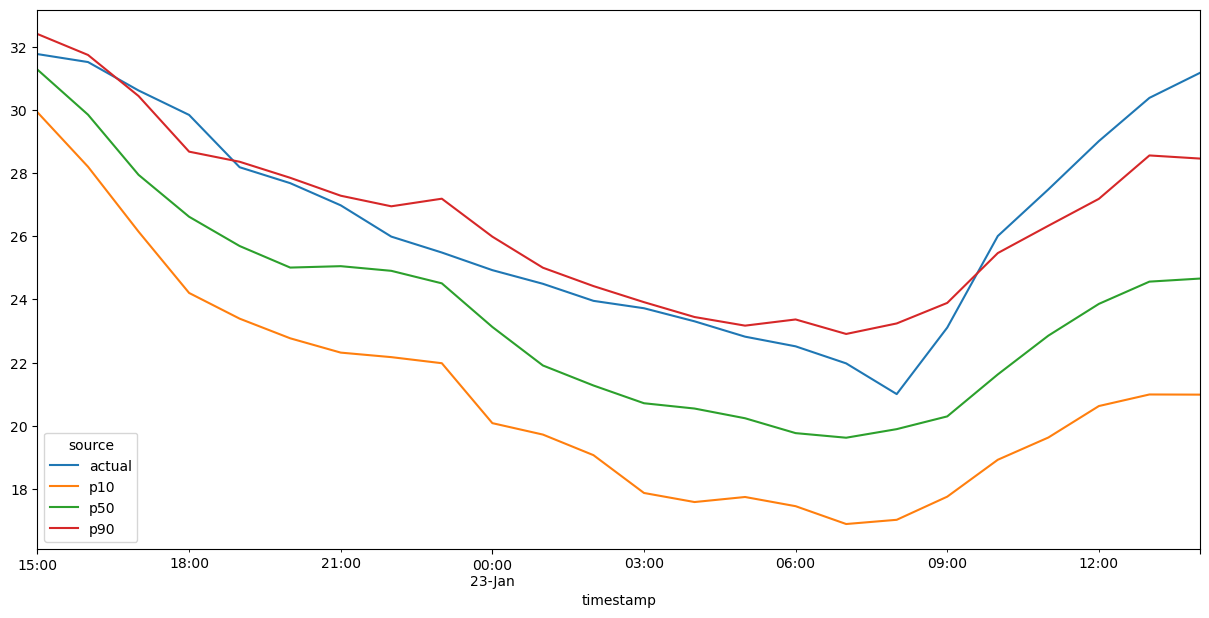

In [10]:
import dateutil.parser

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])
actuals['timestamp'] = actuals['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')


for index, row in actuals.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} , ignore_index=True)
for index, row in forecasts_p10_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in forecasts_p50_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in forecasts_p90_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df.plot(figsize=(15, 7))

## Clean-up <a class="anchor" id="cleanup"></a>
Uncomment the code section to delete all resources that were created in this notebook.

In [ ]:
# forecast.delete_resource_tree(ResourceArn = dataset_group_arn)
# forecast.delete_resource_tree(ResourceArn = ts_dataset_arn)